## Demo inference on MRI T1 image

In [20]:
from __future__ import generators
import logging
import glob, os, functools
import sys

import SimpleITK as sitk
from scipy.signal import medfilt
import numpy as np
from numpy import median
import scipy
import nibabel as nib
import skimage
import matplotlib.pyplot as plt
import scipy.misc
from scipy import ndimage
from skimage.transform import resize,rescale
import cv2
import itk
import subprocess
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.zscore import ZScoreNormalize

import pandas as pd
import tensorflow as tf
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 
    
from scripts.densenet_regression import DenseNet
from scripts.unet import get_unet_2D
from scripts.preprocess_utils import load_nii,save_nii, find_file_in_path,iou, register_to_template,enhance_noN4,crop_center, get_id_and_path
from scripts.feret import Calculater
from settings import  target_size_dense_net, target_size_unet, unet_classes, softmax_threshold, major_voting,scaling_factor
from scripts.infer_selection import get_slice_number_from_prediction, funcy
import warnings

warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [21]:
def select_template_based_on_age(age):
    for golden_file_path, age_values in age_ranges.items():
        if age_values['min_age'] <= int(age) and int(age) <= age_values['max_age']: 
            print(golden_file_path)
            return golden_file_path
        
def register_to_template(input_image_path, output_path, fixed_image_path,rename_id,create_subfolder=True):
    fixed_image = itk.imread(fixed_image_path, itk.F)

    # Import Parameter Map
    parameter_object = itk.ParameterObject.New()
    parameter_object.AddParameterFile('data/golden_image/mni_templates/Parameters_Rigid.txt')

    if "nii" in input_image_path and "._" not in input_image_path:
        print(input_image_path)

        # Call registration function
        try:        
            moving_image = itk.imread(input_image_path, itk.F)
            result_image, result_transform_parameters = itk.elastix_registration_method(
                fixed_image, moving_image,
                parameter_object=parameter_object,
                log_to_console=False)
            image_id = input_image_path.split("/")[-1]
            
            itk.imwrite(result_image, output_path+"/"+rename_id+".nii.gz")
                
            print("Registered ", rename_id)
        except:
            print("Cannot transform", rename_id)
           
        
def filter_islands(muscle_seg):
    img = muscle_seg.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, np.uint8)
    cnt_mask = np.zeros(img.shape, np.uint8)
    area = 0
    c=0
    if len(contours) != 0:
        c = max(contours, key = cv2.contourArea)
        area = cv2.contourArea(c)
        mask = cv2.fillPoly(mask, pts=[c], color=(255, 0, 0))
        cnt_mask =  cv2.drawContours(cnt_mask, [c], -1, (255, 255, 255), 0)#cv.drawContours(cnt_mask, [c], 0, (255,255,0), 2)
    return mask, area, c

In [22]:
# change paths to your paths here

img_path = 'data/t1_mris/nihm_reg/clamp_1193_v1_t1w.nii.gz'#'data/t1_mris/nihm_reg/clamp_1096_v1_t1w.nii.gz' # input raw t1 MRI path
age = 9 # age of subject
model_weight_path_segmentation = 'model/unet_models/test/Top_Segmentation_Model_Weight.hdf5'
model_weight_path_selection = 'model/densenet_models/test/brisk-pyramid.hdf5'
path_to = "./data/bch/" # save to

# MNI templates 
age_ranges = {"data/golden_image/mni_templates/nihpd_asym_04.5-08.5_t1w.nii" : {"min_age":3, "max_age":7},
                "data/golden_image/mni_templates/nihpd_asym_07.5-13.5_t1w.nii": {"min_age":8, "max_age":13},
                "data/golden_image/mni_templates/nihpd_asym_13.0-18.5_t1w.nii": {"min_age":14, "max_age":35}}
threshold = 0.75 # ie must be present on 3 out of 4 predictions

### Preprocessing: register, rescale, normalize

('R', 'A', 'S')
data/golden_image/mni_templates/nihpd_asym_07.5-13.5_t1w.nii
Registering to template: data/golden_image/mni_templates/nihpd_asym_07.5-13.5_t1w.nii
data/t1_mris/nihm_reg/clamp_1193_v1_t1w.nii.gz
Registered  registered.nii.gz


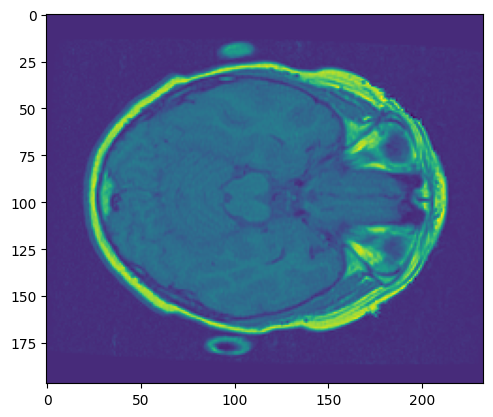

In [23]:
# load image
image, affine = load_nii(img_path)
plt.imshow(image[:,:,65])
print(nib.aff2axcodes(affine))

# path to store registered image in
new_path_to = path_to+img_path.split("/")[-1].split(".")[0]
if not os.path.exists(new_path_to):
    os.mkdir(new_path_to)

# register image to MNI template
golden_file_path = select_template_based_on_age(age)
print("Registering to template:", golden_file_path)
register_to_template(img_path, new_path_to, golden_file_path,"registered.nii.gz", create_subfolder=False)

In [24]:
# enchance and zscore normalize image
if not os.path.exists(new_path_to+"/no_z"):
    os.mkdir(new_path_to+"/no_z")
    
image_sitk =  sitk.ReadImage(new_path_to+"/registered.nii.gz")
image_array  = sitk.GetArrayFromImage(image_sitk)
image_array = enhance_noN4(image_array)
image3 = sitk.GetImageFromArray(image_array)

sitk.WriteImage(image3,new_path_to+"/no_z/registered_no_z.nii") 
cmd_line = "zscore-normalize "+new_path_to+"/no_z/registered_no_z.nii -o "+new_path_to+'/registered_z.nii'
subprocess.getoutput(cmd_line)     
print(cmd_line)
print("Preprocessing done!")

zscore-normalize ./data/bch/clamp_1193_v1_t1w/no_z/registered_no_z.nii -o ./data/bch/clamp_1193_v1_t1w/registered_z.nii
Preprocessing done!


### Load models

In [25]:
# load models
model_selection = DenseNet(img_dim=(256, 256, 1), 
                nb_layers_per_block=12, nb_dense_block=4, growth_rate=12, nb_initial_filters=16, 
                compression_rate=0.5, sigmoid_output_activation=True, 
                activation_type='relu', initializer='glorot_uniform', output_dimension=1, batch_norm=True )
model_selection.load_weights(model_weight_path_selection)
print('\n','\n','\n','loaded:' ,model_weight_path_selection)  
    
model_unet = get_unet_2D(unet_classes,(target_size_unet[0], target_size_unet[1], 1),\
        num_convs=2,  activation='relu',
        compression_channels=[16, 32, 64, 128, 256, 512],
        decompression_channels=[256, 128, 64, 32, 16])
model_unet.load_weights(model_weight_path_segmentation)
print('\n','\n','\n','loaded:' ,model_weight_path_segmentation)  


 
 
 loaded: model/densenet_models/test/brisk-pyramid.hdf5

 
 
 loaded: model/unet_models/test/Top_Segmentation_Model_Weight.hdf5


### Inference - slice detection

In [26]:
image_sitk = sitk.ReadImage(new_path_to+'/registered_z.nii')    
windowed_images  = sitk.GetArrayFromImage(image_sitk)           

In [27]:
resize_func = functools.partial(resize, output_shape=model_selection.input_shape[1:3],
                                            preserve_range=True, anti_aliasing=True, mode='constant')
series = np.dstack([resize_func(im) for im in windowed_images])
series = np.transpose(series[:, :, :, np.newaxis], [2, 0, 1, 3])
series_n = []

for slice_idx in range(2, np.shape(series)[0]-2):
    im_array = np.zeros((256, 256, 1, 5))
    
    # create MIP of 5 slices = 5mm 
    im_array[:,:,:,0] = series[slice_idx-2,:,:,:].astype(np.float32)
    im_array[:,:,:,1] = series[slice_idx-1,:,:,:].astype(np.float32)
    im_array[:,:,:,2] = series[slice_idx,:,:,:].astype(np.float32)
    im_array[:,:,:,3] = series[slice_idx+1,:,:,:].astype(np.float32)
    im_array[:,:,:,4] = series[slice_idx+2,:,:,:].astype(np.float32)
            
    im_array= np.max(im_array, axis=3)
            
    series_n.append(im_array)
    series_w = np.dstack([funcy(im) for im in series_n])
    series_w = np.transpose(series_w[:, :, :, np.newaxis], [2, 0, 1, 3])
        
predictions = model_selection.predict(series_w)
slice_label = get_slice_number_from_prediction(predictions)
print("Predicted slice:", slice_label)

6/6 [==============================] - 1s 26ms/step
Predicted slice: 60


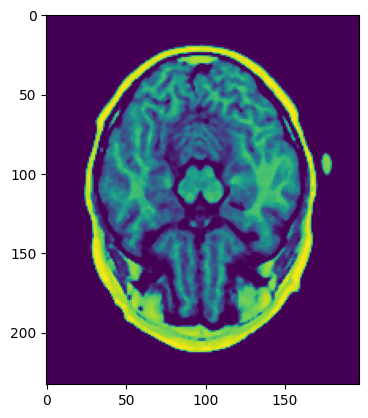

In [28]:
plt.imshow(image_array[slice_label,:,:])

### Inference - segmentation

In [29]:
img = nib.load(new_path_to+'/registered_z.nii')  
image_array, affine = img.get_fdata(), img.affine
infer_seg_array_3d_1,infer_seg_array_3d_2 = np.zeros(image_array.shape),np.zeros(image_array.shape)
print(np.asarray(nib.aff2axcodes(affine)))

['L' 'P' 'S']


In [30]:
# rescale image into 512x512 for unet 
image_array_2d = rescale(image_array[:,15:-21,slice_label], scaling_factor).reshape(1,target_size_unet[0],target_size_unet[1],1) 
            
img_half_11 = np.concatenate((image_array_2d[:,:256,:,:],np.zeros_like(image_array_2d[:,:256,:,:])),axis=1)
img_half_21 = np.concatenate((np.zeros_like(image_array_2d[:,:256,:,:]),image_array_2d[:,:256,:,:]),axis=1)
img_half_12 = np.concatenate((np.zeros_like(image_array_2d[:,256:,:,:]),image_array_2d[:,256:,:,:]),axis=1)
img_half_22 = np.concatenate((image_array_2d[:,256:,:,:],np.zeros_like(image_array_2d[:,256:,:,:])),axis=1)

flipped = np.flip(image_array_2d, axis=1)

flipped_11 = np.concatenate((flipped[:,:256,:,:],np.zeros_like(flipped[:,:256,:,:])),axis=1)
flipped_21 = np.concatenate((np.zeros_like(flipped[:,:256,:,:]),flipped[:,:256,:,:]),axis=1)
flipped_12 = np.concatenate((np.zeros_like(flipped[:,256:,:,:]),flipped[:,256:,:,:]),axis=1)
flipped_22 = np.concatenate((flipped[:,256:,:,:],np.zeros_like(flipped[:,256:,:,:])),axis=1)

list_of_left_muscle = [img_half_11, img_half_21, flipped_12, flipped_22]
list_of_right_muscle = [img_half_12,img_half_22, flipped_11, flipped_21]

list_of_left_muscle_preds = []
list_of_right_muscle_preds = []

for image in list_of_left_muscle: 
    infer_seg_array = model_unet.predict(image)
    muscle_seg = infer_seg_array[:,:,:,1].reshape(1,target_size_unet[0],target_size_unet[1],1)               
    list_of_left_muscle_preds.append(muscle_seg)
                    
for image in list_of_right_muscle: 
    infer_seg_array = model_unet.predict(image)
    muscle_seg = infer_seg_array[:,:,:,1].reshape(1,target_size_unet[0],target_size_unet[1],1)             
    list_of_right_muscle_preds.append(muscle_seg)
                
list_of_left_muscle_preds_halved = [list_of_left_muscle_preds[0][:,:256,:,:],
                                    list_of_left_muscle_preds[1][:,256:,:,:],
                                    np.flip(list_of_left_muscle_preds[2][:,256:,:,:],axis=1),
                                    np.flip(list_of_left_muscle_preds[3][:,:256,:,:],axis=1)]

list_of_right_muscle_preds_halved = [list_of_right_muscle_preds[0][:,256:,:,:],
                                    list_of_right_muscle_preds[1][:,:256,:,:],
                                    np.flip(list_of_right_muscle_preds[2][:,:256,:,:],axis=1),
                                    np.flip(list_of_right_muscle_preds[3][:,256:,:,:],axis=1)]
                
left_half_result = np.mean(list_of_left_muscle_preds_halved, axis=0)<=threshold # <>
right_half_result = np.mean(list_of_right_muscle_preds_halved, axis=0)<=threshold # <>
muscle_seg_1 = np.concatenate((left_half_result,np.zeros_like(left_half_result)),axis=1)
muscle_seg_2 = np.concatenate((np.zeros_like(left_half_result),right_half_result),axis=1)

1/1 [==============================] - 0s 30ms/step


In [31]:
infer_seg_array_3d_1_filtered,infer_seg_array_3d_2_filtered = np.zeros(image_array.shape),np.zeros(image_array.shape)
infer_seg_array_3d_merged_filtered =  np.zeros(image_array.shape)
        
# filter islands
muscle_seg_1_filtered, area_1, cnt_1 = filter_islands(muscle_seg_1[0])
muscle_seg_2_filtered, area_2, cnt_2 = filter_islands(muscle_seg_2[0])

# rescale for the unet
infer_seg_array_2d_1 = rescale(muscle_seg_1[0],1/scaling_factor)
infer_seg_array_2d_2 = rescale(muscle_seg_2[0],1/scaling_factor)
infer_seg_array_2d_1_filtered = rescale(muscle_seg_1_filtered,1/scaling_factor)
infer_seg_array_2d_2_filtered = rescale(muscle_seg_2_filtered,1/scaling_factor)

# save to 3d
infer_seg_array_3d_1[:,:,slice_label] = np.pad(infer_seg_array_2d_1[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)
infer_seg_array_3d_2[:,:,slice_label] = np.pad(infer_seg_array_2d_2[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)
infer_seg_array_3d_1_filtered[:,:,slice_label] = np.pad(infer_seg_array_2d_1_filtered[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)
infer_seg_array_3d_2_filtered[:,:,slice_label] = np.pad(infer_seg_array_2d_2_filtered[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)
            
concated = np.concatenate((infer_seg_array_2d_1_filtered[:100,:,0],infer_seg_array_2d_2_filtered[100:,:,0]),axis=0)    
infer_seg_array_3d_merged_filtered[:,:,slice_label] = np.pad(concated,[[0,0],[15,21]],'constant',constant_values=0)
#infer_3d_path = output_dir+"/pics/"+patient_id + '_AI_seg.nii.gz'
#save_nii(infer_seg_array_3d_merged_filtered, infer_3d_path, affine)
             

In [32]:
from compute_population_pred import major_voting, measure_tm, filter_islands,compute_crop_line


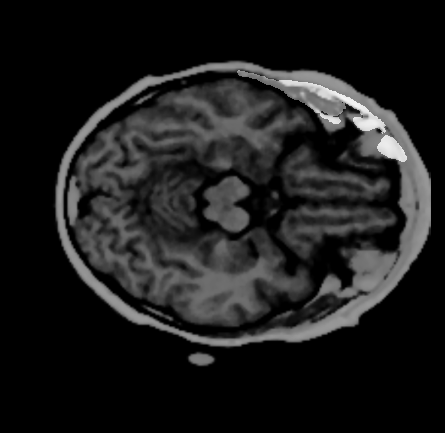

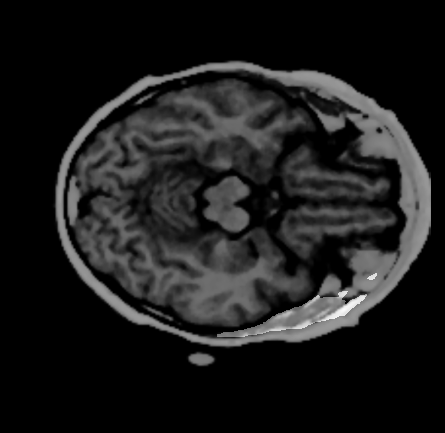

In [33]:
fg=plt.figure(figsize=(5, 5), facecolor='k')
plt.imshow(image_array_2d[0],'gray')
plt.imshow(muscle_seg_1[0], 'gray', alpha=0.4, interpolation='none')
plt.show()

fg=plt.figure(figsize=(5, 5), facecolor='k')
plt.imshow(image_array_2d[0],'gray')
plt.imshow(muscle_seg_2[0], 'gray', alpha=0.4, interpolation='none')
plt.show()

### Compute TMT and CSA

In [34]:
def compute_crop_line(img_input,infer_seg_array_2d_1,infer_seg_array_2d_2):
    binary = img_input>-1.7
    binary_smoothed = scipy.signal.medfilt(binary.astype(int), 51)
    img = binary_smoothed.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, np.uint8)
    img = cv2.drawContours(mask, contours, -1, (255),1)

    max_y,ind_max = 0,0
    min_y,ind_min = 512,0
    if len(contours)>0:
        for i in range(0,len(contours[0])):
            x,y = contours[0][i][0]
            if y<=min_y:
                min_y,ind_min = y,i
            if y>=max_y:
                max_y,ind_max = y,i
        print(min_y,contours[0][ind_min][0])
        print(max_y,contours[0][ind_max][0])

        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax.imshow(img_input, interpolation=None, cmap=plt.cm.Greys_r)
        ax.imshow(infer_seg_array_2d_1,cmap='jet',alpha=0.5)
        ax.imshow(infer_seg_array_2d_2,cmap='jet',alpha=0.5)
        crop_line = (contours[0][ind_min][0][0]+contours[0][ind_max][0][0])/2
        
        ax.plot((crop_line, crop_line),
                (contours[0][ind_min][0][1], contours[0][ind_max][0][1]), lw=1, c='b')

        fig.show()

        return crop_line
    else:
        return 100

30 [113  30]
166 [100 166]


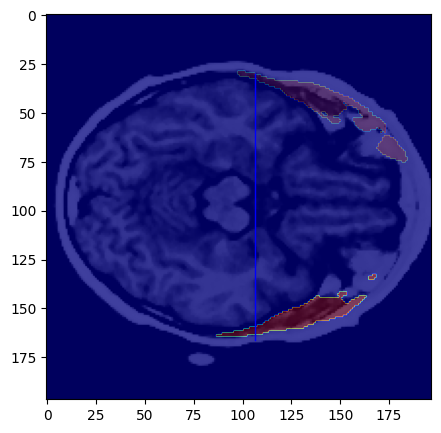

In [35]:
infer_seg_array_2d_1 = rescale(muscle_seg_1[0],1/scaling_factor)
infer_seg_array_2d_2 = rescale(muscle_seg_2[0],1/scaling_factor)

infer_seg_array_3d_1[:,:,slice_label] = np.pad(infer_seg_array_2d_1[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)
infer_seg_array_3d_2[:,:,slice_label] = np.pad(infer_seg_array_2d_2[:,:,0],[[0,0],[15,21]],'constant',constant_values=0)

objL_pred_minf_line, objR_pred_minf_line, objL_pred_minf, objR_pred_minf = 0,0,0,0
                
crop_line = compute_crop_line(image_array[:,15:-21,slice_label],infer_seg_array_2d_1,infer_seg_array_2d_2)
                
if np.sum(infer_seg_array_3d_1[:100,:,slice_label])>2:
    objL_pred_minf = round(Calculater(infer_seg_array_3d_1[:100,:,slice_label], edge=True).minf,2)

if np.sum(infer_seg_array_3d_2[100:,:,slice_label])>2:
    objR_pred_minf = round(Calculater(infer_seg_array_3d_2[100:,:,slice_label], edge=True).minf,2)
            
CSA_PRED_TM1 = np.sum(infer_seg_array_3d_1[:100,:,slice_label])
CSA_PRED_TM2 = np.sum(infer_seg_array_3d_2[100:,:,slice_label])
                    
if np.sum(infer_seg_array_3d_1[:100,int(crop_line):,slice_label])>2:
    objL_pred_minf_line = round(Calculater(infer_seg_array_3d_1[:100,int(crop_line):,slice_label], edge=True).minf,2)

if np.sum(infer_seg_array_3d_2[100:,int(crop_line):,slice_label])>2:
    objR_pred_minf_line = round(Calculater(infer_seg_array_3d_2[100:,int(crop_line):,slice_label], edge=True).minf,2)
                
CSA_PRED_TM1_line = np.sum(infer_seg_array_3d_1[:100,int(crop_line):,slice_label])
CSA_PRED_TM2_line = np.sum(infer_seg_array_3d_2[100:,int(crop_line):,slice_label])
            

In [38]:
Calculater(infer_seg_array_3d_1[:,:,slice_label], edge=True).minf

18.224276675770415

In [39]:
Calculater(infer_seg_array_3d_1[:,:,slice_label], edge=True).maxf90

18.625702094779946

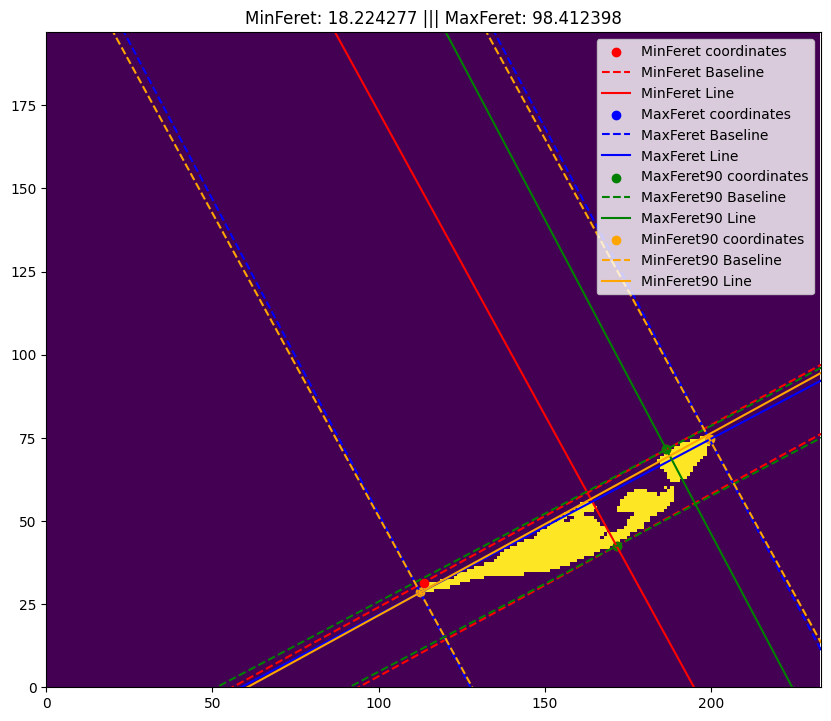

In [36]:
Calculater(infer_seg_array_3d_1[:,:,slice_label], edge=True).plot()

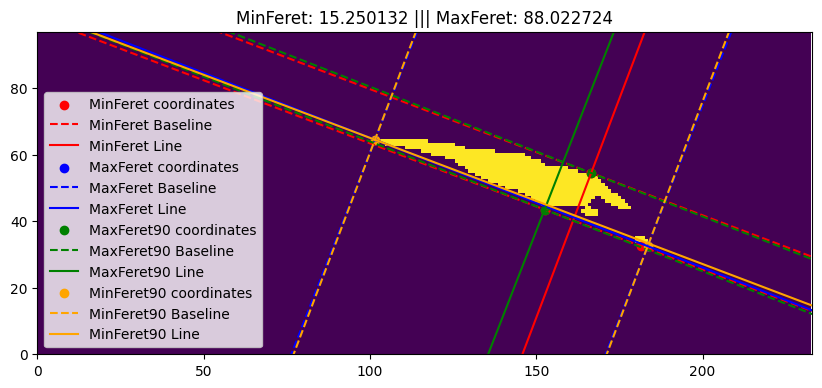

In [37]:
Calculater(infer_seg_array_3d_2[100:,:,slice_label], edge=True).plot()